# 第 14 章 生成式对抗网络

## 14.2 搭建生成式对抗网络

### 14.2.1 生成器

In [1]:
import numpy as np
from tensorflow import keras

L = keras.layers

LATENT_DIM = 100 # 潜在空间维度
IMAGE_SHAPE = (28, 28, 1) # 输出图像尺寸

generator_net = [
    L.Input(shape=(LATENT_DIM, )),
    L.Dense(256),
    L.LeakyReLU(alpha=0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(512),
    L.LeakyReLU(alpha=0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(1024),
    L.LeakyReLU(alpha=0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(np.prod(IMAGE_SHAPE), activation='tanh'),
    L.Reshape(IMAGE_SHAPE),
]

generator = keras.models.Sequential(generator_net)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

### 14.2.2 判别器

In [2]:
# 判别器模型的层列表
discriminator_net = [
    L.Input(shape=IMAGE_SHAPE),
    L.Flatten(),
    L.Dense(512),
    L.LeakyReLU(alpha=0.2),
    L.Dense(256),
    L.LeakyReLU(alpha=0.2),
    L.Dense(1, activation='sigmoid'),
]

optimizer = keras.optimizers.Adam(0.0002, 0.5)

discriminator = keras.models.Sequential(discriminator_net)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

### 14.2.3 对抗模型

In [3]:
# 对抗模型使用生成器模型层和判别器模型层，它们共享权重
adversarial_net = generator_net + discriminator_net

# 冻结判别器的权重
# trainable 属性只有编译后生效，所以之前的判别器模型同样的层还是可以训练的
for layer in discriminator_net:
    layer.trainable = False

adversarial = keras.models.Sequential(adversarial_net)

# 编译对抗模型
optimizer = keras.optimizers.Adam(0.0002, 0.5)
adversarial.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def sample_images():
    rows, columns = 3, 10
    sample_count = rows * columns

    plt.figure(figsize=(columns, rows))

    # 使用生成器生成图像
    noise = np.random.normal(0, 1, (sample_count, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    # 生成器图像张量范围从 [-1, 1] 改到 [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    index = 0
    for row in range(rows):
        for col in range(columns):
            image = np.reshape(gen_imgs[index], [28, 28])
            plt.subplot(rows, columns, index+1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            index += 1
    plt.tight_layout()
    plt.show()
    return gen_imgs

In [20]:
import tqdm

def train(epochs=20, batch_size=64):
    training_samples = []
    training_history = []

    # 读取数据集，我们只需要图像数据，不需要标签和测试数据。
    (image_set, _), (_, _) = keras.datasets.mnist.load_data()

    # 数据归一化
    image_set = image_set / 127.5 - 1.
    # 数据格式转换 [count, 28, 28] -> [count, 28, 28, 1]
    image_set = image_set.reshape(len(image_set), 28, 28, 1)

    # 准备 batch_size 大小的真假数据标签
    valid = np.ones((batch_size))
    fake = np.zeros((batch_size))

    batch_count = int(len(image_set) / batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        for batch in tqdm.trange(batch_count):
            # ------ 生成器生成图像 ------
            # 随机选择 batch_size 数量的数据作为训练数据
            noise = np.random.uniform(-1, 1, (batch_size, LATENT_DIM))
            imgs = image_set[batch * batch_size:(batch + 1) * batch_size]

            # 生成噪音数据作为生成器输入
            noise = np.random.uniform(-1, 1, (batch_size, LATENT_DIM))

            # 使用生成器生成生成图像
            gen_imgs = generator.predict(noise)

            # ------ 训练判别器 ------
            # 使用真实图像和生成图像训练判别器，真实图像标签全部为 1，生成图像标签全部为 0
            d_state_real = discriminator.train_on_batch(imgs, valid)
            d_state_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_state = 0.5 * np.add(d_state_real, d_state_fake)

            # ------ 训练生成器 ------
            # 生成噪音数据作为对抗模型
            noise = np.random.uniform(-1, 1, (batch_size, LATENT_DIM))

            # 训练对抗模型，目标是生成判别器认为真实图像的图像，所以标签为 1
            # 由于对抗模型中的判别器的层都冻结了，所以实际上在训练生成器，不断生成更加逼真的图像
            adv_state = adversarial.train_on_batch(noise, valid)

            training_history.append([*d_state, *adv_state])
            # 更新进度条后缀，用于输出训练进度
#             state = f"[D loss: {d_state[0]:.4f} acc: {d_state[1]:.4f}] " \
#                     f"[A loss: {adv_state[0]:.4f} acc: {adv_state[1]:.4f}"
#             print(state)
            
        # 清空 cell 之前的输出
        clear_output(wait=True)
        samples = sample_images()
        training_samples.append((batch, samples))

    return training_history, training_samples

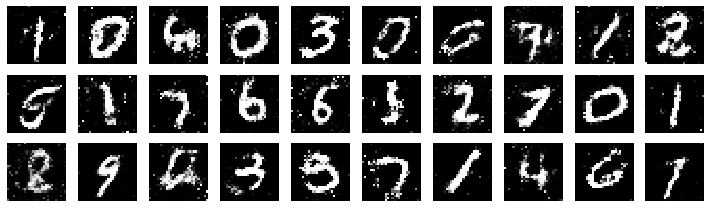

  0%|          | 2/937 [00:00<01:03, 14.80it/s]

Epoch 3/20


 23%|██▎       | 220/937 [00:15<00:50, 14.12it/s]


KeyboardInterrupt: 

In [21]:
# 调用 train 函数就可以开始训练了
history, samples  = train(epochs=20, batch_size=64)

#### 可视化训练过程

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

def visualize_samples(train_samples):
    nrows, ncols = 3, 5
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    
    for index, ax in enumerate(axs.flatten()):
        ax.axis('off')
        sample_index = int(len(train_samples) / (nrows * ncols)) * index
    
        if sample_index < len(train_samples):
            batch, images = train_samples[sample_index]
            row0 = np.concatenate((images[0], images[1], images[2]), axis=1)
            row1 = np.concatenate((images[3], images[4], images[5]), axis=1)
            row2 = np.concatenate((images[6], images[7], images[8]), axis=1)
            image = np.concatenate((row0, row1, row2))
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(batch)        
    plt.show()

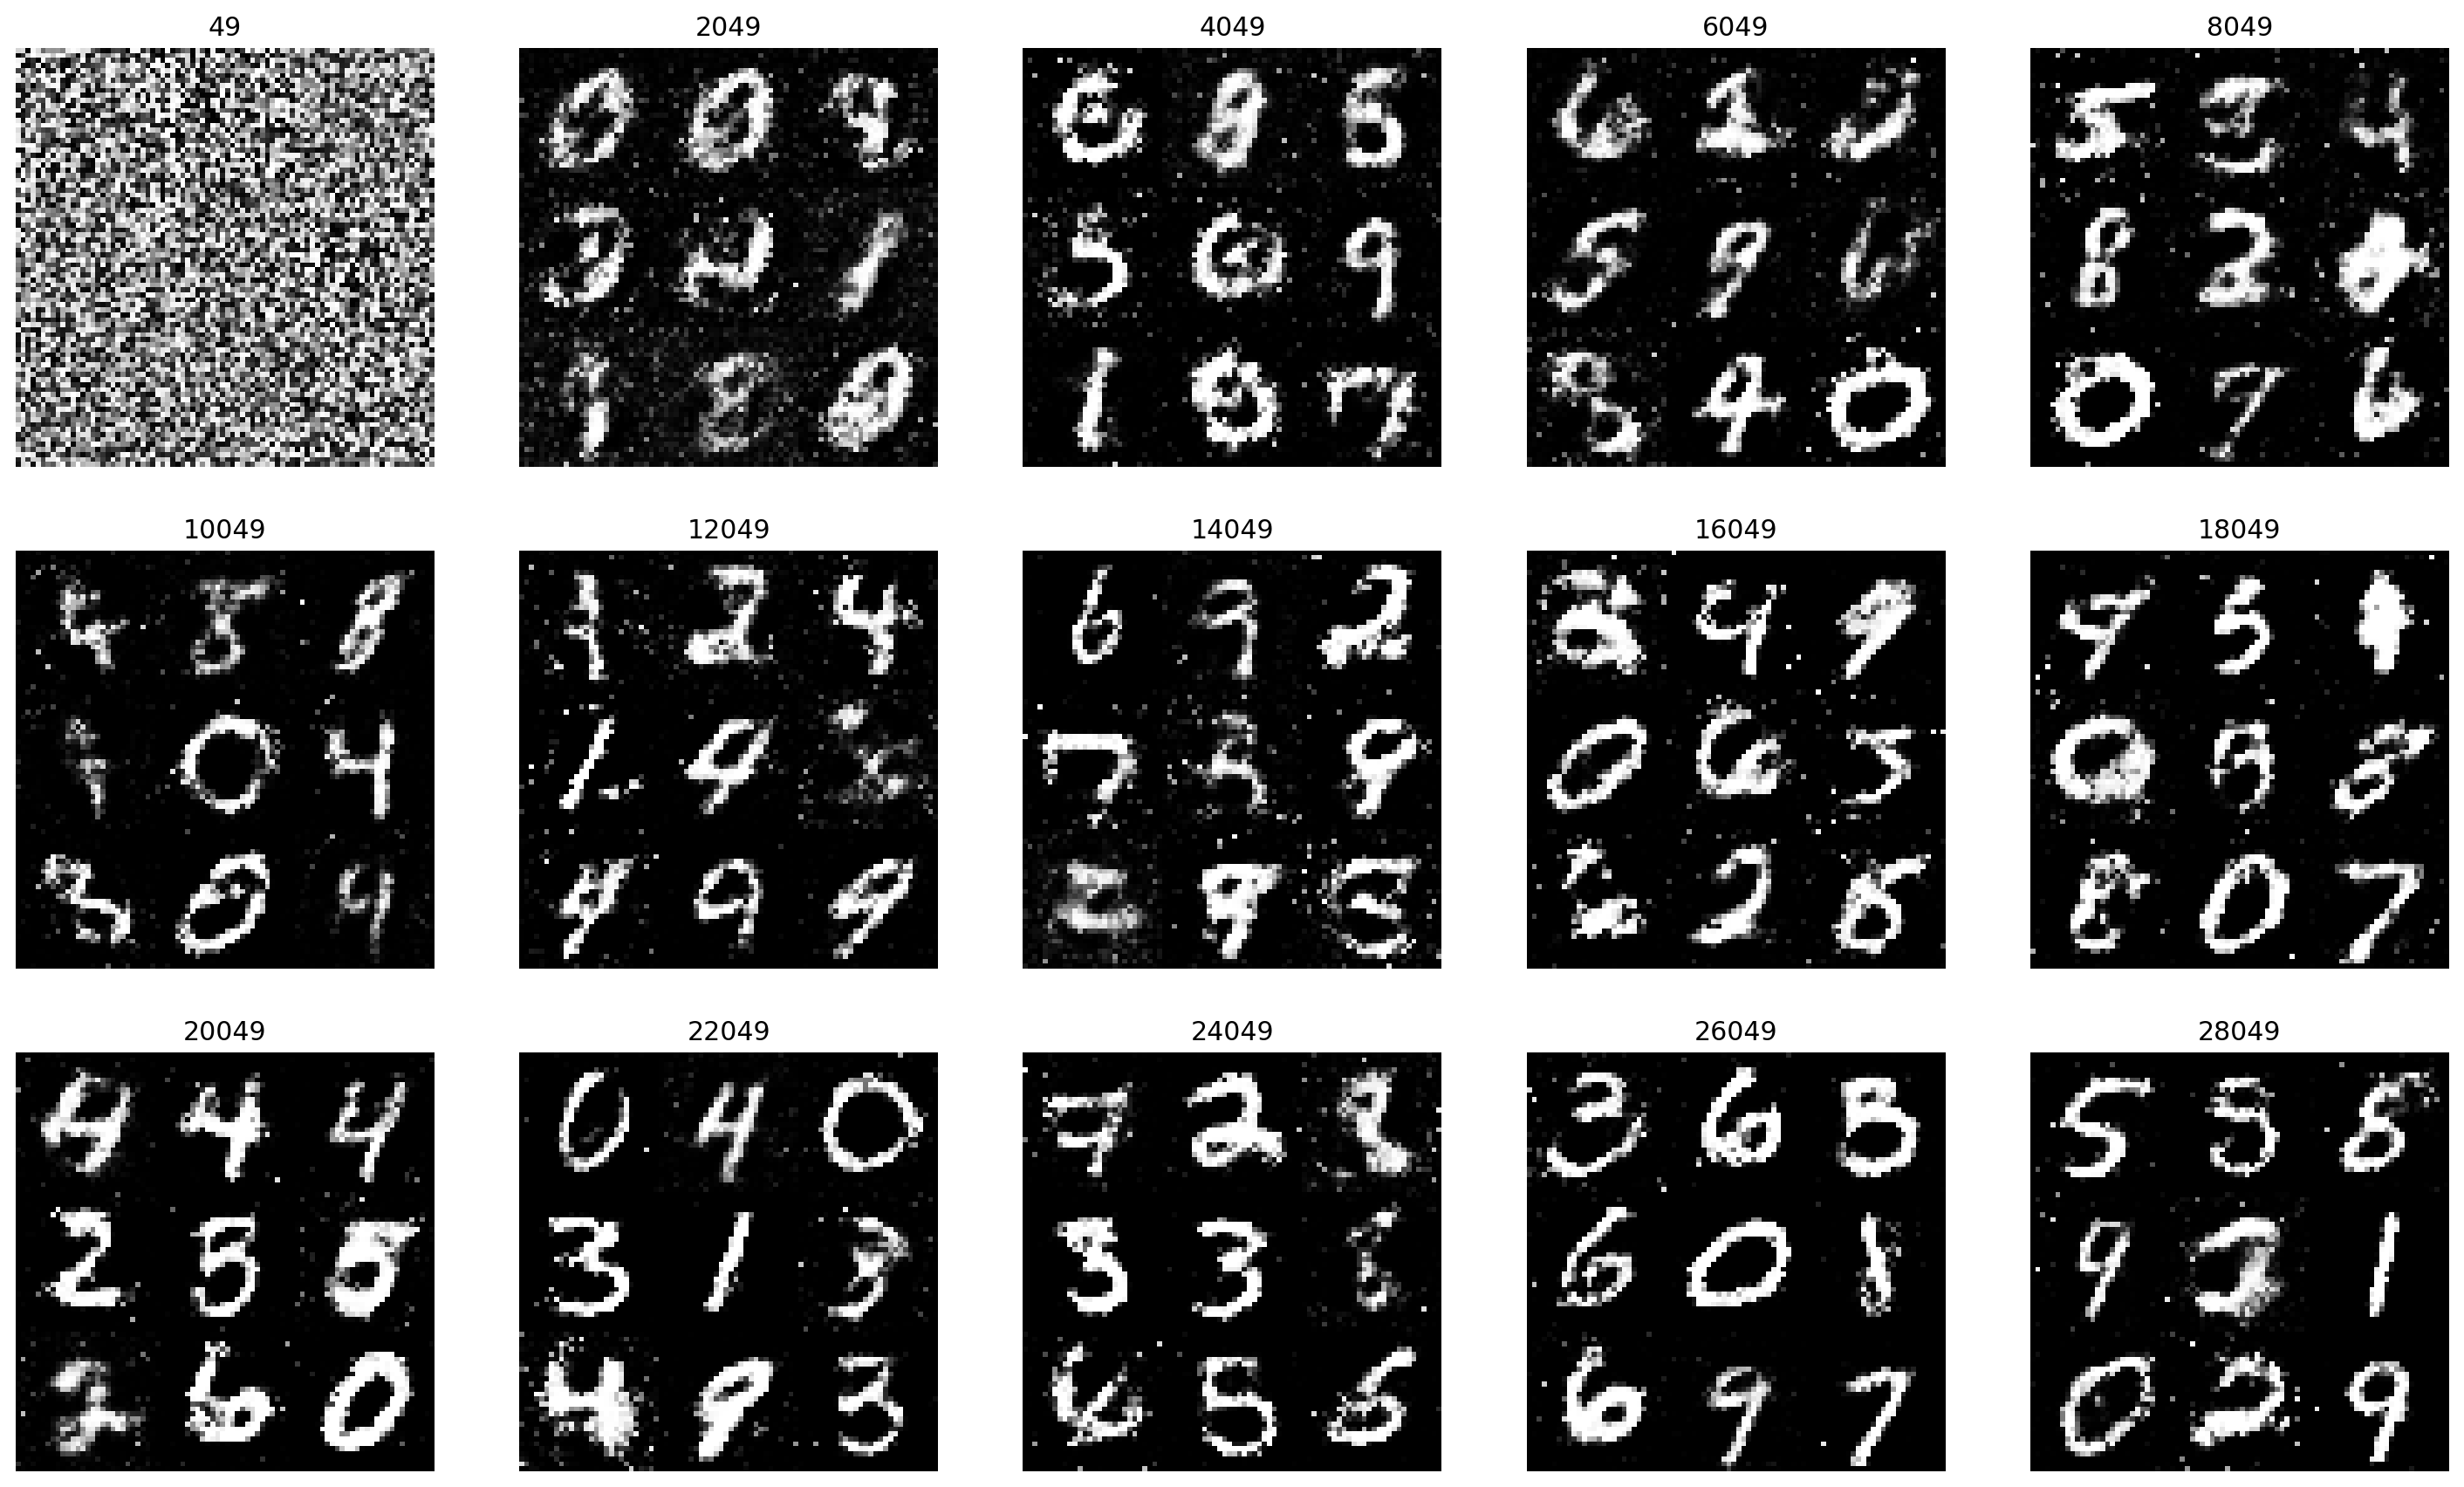

In [8]:
visualize_samples(samples)